In [1]:
'''
Created on 2023-08-29 13:54:46
@author: caitgrasso
'''

'\nCreated on 2023-08-29 13:54:46\n@author: caitgrasso\n'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from collections import Counter
from skimage import segmentation
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import os
from collections import Counter

Load data

In [3]:
BOT = 'bot_01'

# read in functional connectivity matrices
FC1 = np.loadtxt(f'../network_inference_data/fc_matrices/{BOT}_before_mimat_w.csv', delimiter=',')
FC2 = np.loadtxt(f'../network_inference_data/fc_matrices/{BOT}_after_mimat_w.csv', delimiter=',')
N1 = FC1.shape[0]
N2 = FC2.shape[1]

# read in consensus partitions
consensus_partition1 = np.loadtxt(f'../network_analysis_data/community_detection/{BOT}_before_mimat_w_consensus_partition.csv', delimiter=',')
consensus_partition2 = np.loadtxt(f'../network_analysis_data/community_detection/{BOT}_after_mimat_w_consensus_partition.csv', delimiter=',')

In [4]:
# Load  bot images
img_before = cv2.cvtColor(cv2.imread(f'../bot_images/{BOT}_before_00001.tiff'), cv2.COLOR_BGR2GRAY)
img_after = cv2.cvtColor(cv2.imread(f'../bot_images/{BOT}_after_00001.tiff'), cv2.COLOR_BGR2GRAY)

# Load spatial data
pixel_df_before = pd.read_csv('../spatial_data/raw_spatial/{}_before_pixels.csv'.format(BOT), header=0)
pixel_df_after = pd.read_csv('../spatial_data/raw_spatial/{}_after_pixels.csv'.format(BOT), header=0)

com_df_before = pd.read_csv('../spatial_data/raw_spatial/{}_before_centroids.csv'.format(BOT), header=0)
com_df_after = pd.read_csv('../spatial_data/raw_spatial/{}_after_centroids.csv'.format(BOT), header=0)


In [5]:
# Load raw signals
series_gsr_w_before = np.loadtxt('../network_inference_data/series_gsr_whitened/{}_before_entrate.csv'.format(BOT), delimiter=',')
series_gsr_w_after = np.loadtxt('../network_inference_data/series_gsr_whitened/{}_after_entrate.csv'.format(BOT), delimiter=',')

In [6]:
os.makedirs('../results/modularity/', exist_ok=True)
os.makedirs(f'../results/modularity/{BOT}/', exist_ok=True)

In [7]:
plt.rcParams.update({'font.size': 15, 'font.family': 'arial'})
# CMAP1 = ['b', 'g', 'r']
# CMAP2 = ['c', 'm', 'y']

CMAP1 = ['tab:blue', 'tab:green', 'tab:orange']
CMAP2 = ['tab:cyan', 'tab:pink', 'tab:olive']

Define functions

In [8]:
def paint_modules(ax, partition, pixels, comms_sorted_by_size, img, N=3, cmap=CMAP1):
    
    # print(comms_sorted_by_size)

    for i in range(N):
        
        if comms_sorted_by_size[i][1]>1: # must have more than one member

            comm_id = comms_sorted_by_size[i][0]

            assert np.sum(partition==comm_id)==comms_sorted_by_size[i][1]

            node_ids_in_comm_mask = partition==comm_id

            node_ids_in_comm = np.indices(node_ids_in_comm_mask.shape).reshape(len(node_ids_in_comm_mask))[node_ids_in_comm_mask]

            # print(node_ids_in_comm)

            for node_id in node_ids_in_comm:

                # Get all pixel locations with that node id

                # print(pixels[pixels["series_index"]==node_id])

                x_locs = list(pixels[pixels["series_index"]==node_id]["x"])
                y_locs = list(pixels[pixels["series_index"]==node_id]["y"])

                # Mark boundaries on image
                labeled_im = np.zeros(img.shape,dtype=int)
                labeled_im[x_locs,y_locs]=2
                boundary_mat = segmentation.find_boundaries(labeled_im, background=0, connectivity=2)
                
                mat = np.multiply(labeled_im, boundary_mat)

                mycmap = ListedColormap([[1, 1, 1, 0], cmap[i], cmap[i]])
                ax.matshow(labeled_im, cmap=mycmap)


In [9]:
def paint_sqaures(ax, partition, comms_sorted_by_size, N=3, cmap=CMAP1):
    sorted_partition = np.asarray(sorted(partition)).astype(int)

    for i in range(N):
        
        if comms_sorted_by_size[i][1]>1: # must have more than one member

            comm_id = int(comms_sorted_by_size[i][0])
            
            inds = np.arange(len(sorted_partition))
            inds_square = inds[sorted_partition==comm_id]

            ax.add_patch(Rectangle((inds_square[0]-0.5, inds_square[0]-0.5), inds_square[-1]-inds_square[0]+1, inds_square[-1]-inds_square[0]+1, color=cmap[i], fill=False, linewidth=2)) # offset everything by 0.5 so the line is on the outside of the cell

In [10]:
def plot_edges(ax, mat, com_df, color=(0,0,1,0.6)):
    mat_vals = mat[np.triu_indices(mat.shape[0],k=1)]
    mat_edges_r,mat_edges_c = np.triu_indices(mat.shape[0],k=1)

    for i in range(len(mat_vals)):
        val = mat_vals[i]
        nodei_id = mat_edges_r[i]
        nodej_id = mat_edges_c[i]

        x1 = com_df.iloc[nodei_id]["y"]      
        y1 = com_df.iloc[nodei_id]["x"]      
        
        x2 = com_df.iloc[nodej_id]["y"]      
        y2 = com_df.iloc[nodej_id]["x"]  

        ax.plot([x1,x2],[y1,y2], c=color, linewidth=val, zorder=1, alpha=0.5)  

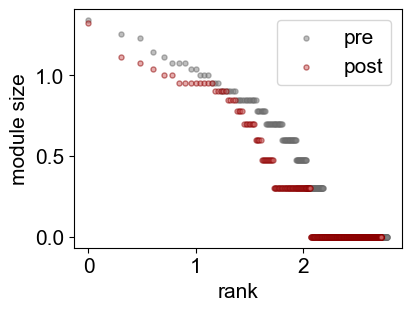

In [11]:
fig,ax = plt.subplots(figsize=(4,3), layout='constrained')
data_before = sorted(list(Counter(consensus_partition1).values()), reverse=True)
x = np.arange(1,len(data_before)+1)
# ax.scatter(x, data_before, s=13, edgecolors='dimgray', facecolors='gray', alpha=0.5)
ax.scatter(np.log10(x), np.log10(data_before), s=13, edgecolors='dimgray', facecolors='gray', alpha=0.5)

data_after = sorted(list(Counter(consensus_partition2).values()), reverse=True)
x = np.arange(1,len(data_after)+1)
# ax.scatter(x, data_after, s=13, edgecolors='darkred', facecolors='indianred', alpha=0.5)
ax.scatter(np.log10(x), np.log10(data_after), s=13, edgecolors='darkred', facecolors='indianred', alpha=0.5)



# ax.annotate('module 1', (x[0]+3,data[0]), color=CMAP1[0])
# ax.annotate('module 2', (x[1]+3,data[1]), color=CMAP1[1])
# ax.annotate('module 3', (x[2]+3,data[2]), color=CMAP1[2])
plt.xlabel('rank')
# plt.ylim([0,30])
plt.ylabel('module size')
plt.legend(['pre','post'])


plt.savefig(f'../../../Desktop/{BOT}_module_sizes.png', dpi=500, bbox_inches='tight')
plt.show()

### Functional connectivity reordered by modularity

In [12]:
I1 = sorted(range(len(consensus_partition1)), key=lambda k: consensus_partition1[k])
I2 = sorted(range(len(consensus_partition2)), key=lambda k: consensus_partition2[k])

In [13]:
comms_sorted_by_size1 = sorted(dict(Counter(consensus_partition1)).items(), key = lambda item : item[1], reverse=True) #[(mod_id, count)
print(comms_sorted_by_size1[:3])
comms_sorted_by_size2 = sorted(dict(Counter(consensus_partition2)).items(), key = lambda item : item[1], reverse=True) #[(mod_id, count)
print(comms_sorted_by_size1[:3])

[(262.0, 22), (83.0, 18), (6.0, 17)]
[(262.0, 22), (83.0, 18), (6.0, 17)]


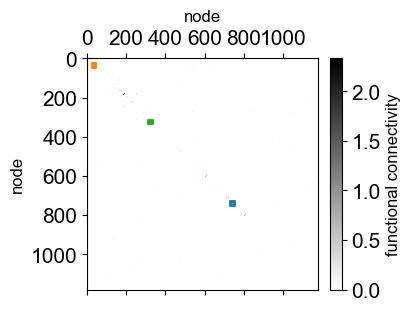

In [88]:
fig,ax = plt.subplots(layout="constrained", figsize=(4,3))
matshow = ax.matshow(FC1[I1][:,I1], cmap='binary')
paint_sqaures(ax, consensus_partition1, comms_sorted_by_size1, cmap=CMAP1)
cbar = fig.colorbar(matshow,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('functional connectivity', fontsize=12)
plt.title('node', fontsize=12)
plt.ylabel('node', fontsize=12)
plt.savefig(f'../results/modularity/{BOT}/{BOT}_reorderedFC_before.png', dpi=500, bbox_inches='tight')

plt.show()

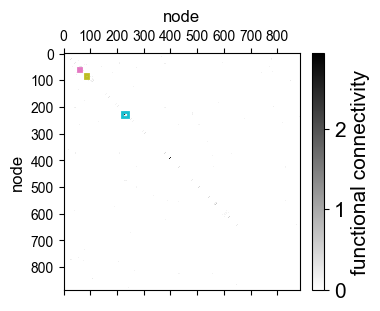

In [89]:
fig,ax = plt.subplots(layout="constrained", figsize=(4,3))
matshow = ax.matshow(FC2[I2][:,I2], cmap='binary')
paint_sqaures(ax, consensus_partition2, comms_sorted_by_size2, cmap=CMAP2)
cbar = fig.colorbar(matshow,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('functional connectivity')
plt.title('node',fontsize=12)
plt.ylabel('node',fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.savefig(f'../results/modularity/{BOT}/{BOT}_reorderedFC_after.png', dpi=500, bbox_inches='tight')

### Modules painted on explant

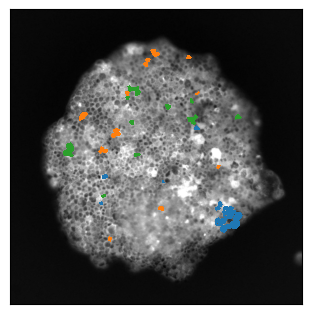

In [90]:
fig,ax = plt.subplots(layout="constrained", figsize=(3,4))
ax.imshow(img_before,cmap='gray')
paint_modules(ax, consensus_partition1, pixel_df_before, comms_sorted_by_size1, img_before, cmap=CMAP1)
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False, labeltop=False, which='both')
plt.savefig(f'../results/modularity/{BOT}/{BOT}_before_explant_with_modules.png', dpi=500, bbox_inches='tight')
plt.show()

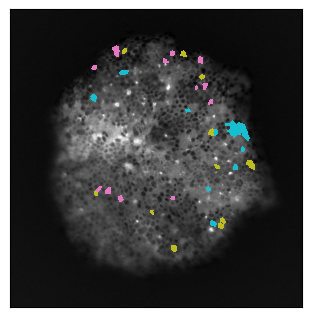

In [91]:
fig,ax = plt.subplots(layout="constrained", figsize=(3,4))
ax.imshow(img_after,cmap='gray')
paint_modules(ax, consensus_partition2, pixel_df_after, comms_sorted_by_size2, img_after,  cmap=CMAP2)
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False, labeltop=False, which='both')
plt.savefig(f'../results/modularity/{BOT}/{BOT}_after_explant_with_modules.png', dpi=500, bbox_inches='tight')
plt.show()

In [11]:
EDGE_COLOR = 'lightblue'
NODE_COLOR_BEFORE = []
NODE_SIZES_BEFORE = []

for row in com_df_before.iterrows():
    color_set = False
    for i in range(3):
        mask = consensus_partition1==comms_sorted_by_size1[i][0]
        if int(row[1]['series_index']) in list(np.indices(mask.shape).reshape(len(mask))[mask]):
            NODE_COLOR_BEFORE.append(CMAP1[i])
            NODE_SIZES_BEFORE.append(15)
            color_set = True
    if not color_set:
        NODE_COLOR_BEFORE.append('gray')
        NODE_SIZES_BEFORE.append(7)


NODE_COLOR_AFTER = []
NODE_SIZES_AFTER = []

for row in com_df_after.iterrows():
    color_set = False
    for i in range(3):
        mask = consensus_partition2==comms_sorted_by_size2[i][0]
        if int(row[1]['series_index']) in list(np.indices(mask.shape).reshape(len(mask))[mask]):
            NODE_COLOR_AFTER.append(CMAP2[i])
            NODE_SIZES_AFTER.append(15)
            color_set = True
    if not color_set:
        NODE_COLOR_AFTER.append('gray')
        NODE_SIZES_AFTER.append(7)



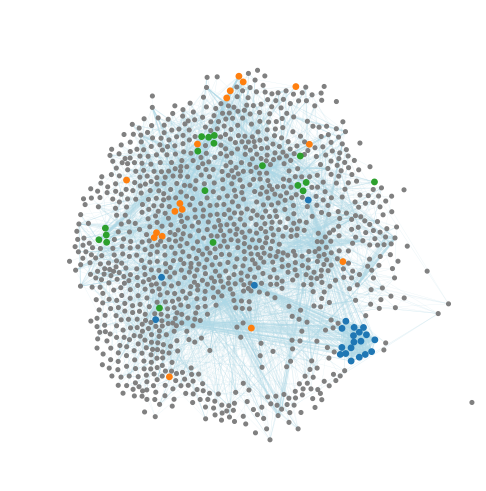

In [15]:
# Plot nodes 

fig,ax = plt.subplots(layout='constrained')

# FC
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.setp(ax.spines.values(), visible=False)

background = np.ones((img_before.shape[0], img_before.shape[1])) # so nodes are in the same position as segmented cells above
ax.imshow(background, cmap='binary')
plot_edges(ax, FC1, com_df_before, color=EDGE_COLOR)
ax.scatter(com_df_before["y"], com_df_before["x"], c=NODE_COLOR_BEFORE, s=NODE_SIZES_BEFORE)

plt.savefig(f'../results/modularity/{BOT}/{BOT}_before_network_with_modules.png', dpi=500, bbox_inches='tight')
plt.show()

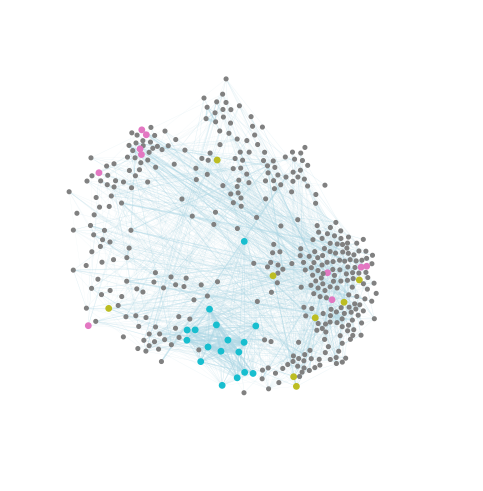

In [ ]:
fig,ax = plt.subplots(layout='constrained')

# FC
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.setp(ax.spines.values(), visible=False)

background = np.ones((img_after.shape[0], img_after.shape[1])) # so nodes are in the same position as segmented cells above
ax.imshow(background, cmap='binary')
plot_edges(ax, FC2, com_df_after, color=EDGE_COLOR)
ax.scatter(com_df_after["y"], com_df_after["x"], c=NODE_COLOR_AFTER, s=NODE_SIZES_AFTER)

plt.savefig(f'../results/modularity/{BOT}/{BOT}_after_network_with_modules.png', dpi=500, bbox_inches='tight')
plt.show()

### Calcium time series of specific nodes

Before

[29, 37, 62, 152, 208]
[176  49 120 196  70 199]


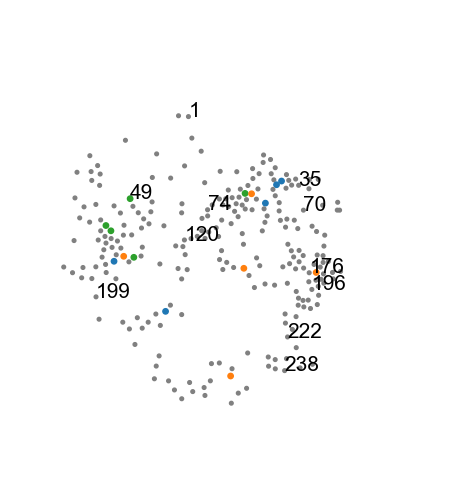

In [ ]:
# Find nodes of interest
MODULE = 0 # largest module
mask = consensus_partition1==comms_sorted_by_size1[MODULE][0]
nodes_idxs_in_modules = list(np.indices(mask.shape).reshape(len(mask))[mask])
before_nodes_of_interest = [1,35,74,222,238,257] # bot_04 before, module 0 - first look at all nodes

np.random.seed(0)
all_node_idxs = list(com_df_before["series_index"])
remaining_nodes = list(set(all_node_idxs) - set(nodes_idxs_in_modules))
random_nodes_idxs = np.random.choice(remaining_nodes, 6).astype(int)

fig,ax = plt.subplots(layout='constrained')

# FC
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.setp(ax.spines.values(), visible=False)

background = np.ones((img_before.shape[0], img_before.shape[1])) # so nodes are in the same position as segmented cells above
ax.imshow(background, cmap='binary')
ax.scatter(com_df_before["y"], com_df_before["x"], c=NODE_COLOR_BEFORE, s=NODE_SIZES_BEFORE)

for row in com_df_before.iterrows():
    idx = int(row[1]['series_index'])
    if idx in before_nodes_of_interest:
        ax.annotate(idx, (com_df_before[com_df_before['series_index']==idx]["y"], com_df_before[com_df_before['series_index']==idx]["x"]))
    elif idx in random_nodes_idxs:
        ax.annotate(idx, (com_df_before[com_df_before['series_index']==idx]["y"], com_df_before[com_df_before['series_index']==idx]["x"]))
print(nodes_idxs_in_modules)
print(random_nodes_idxs)
plt.savefig(f'../results/modularity/{BOT}/{BOT}_before_network_key.png', dpi=500, bbox_inches='tight')
plt.show()

IndexError: index 257 is out of bounds for axis 0 with size 252

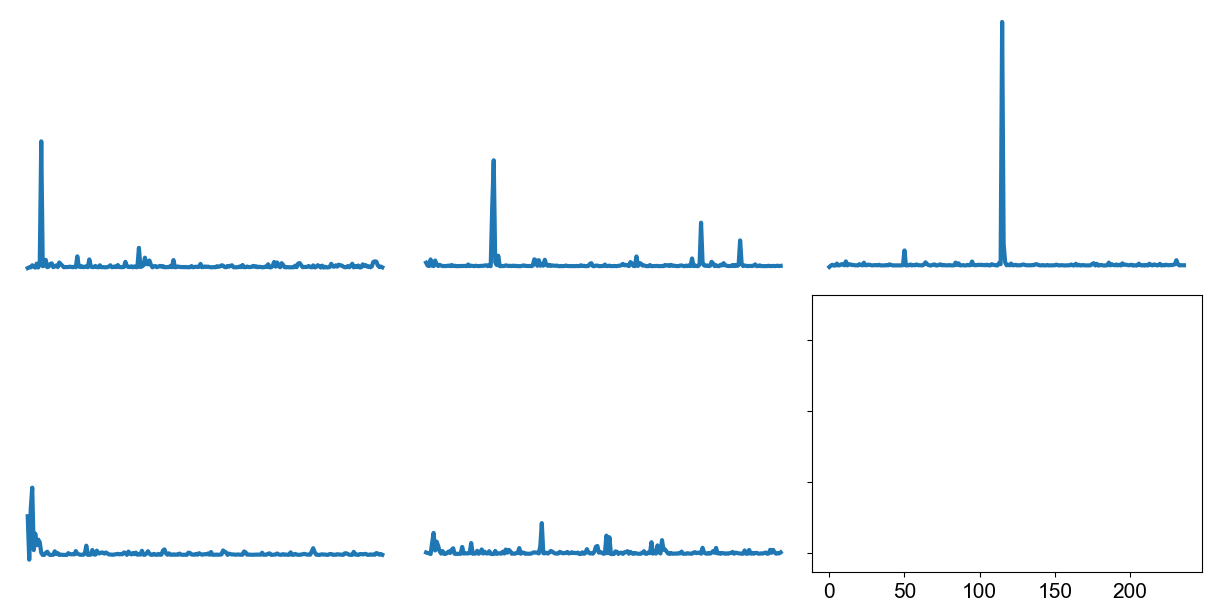

In [21]:
fig,ax = plt.subplots(2,3,figsize=(12,6),sharex=True, sharey=True, layout='constrained')
axes = ax.ravel()


for i in range(len(axes)):

    node_series = series_gsr_w_before[before_nodes_of_interest[i],:]

    axes[i].plot(node_series, CMAP1[MODULE], linewidth=3)
    # axes[i].set_title(before_nodes_of_interest[i])
    axes[i].axis('off')
plt.suptitle('Calcium time series (GSR + whitened)', fontsize=30)
plt.savefig(f'../results/modularity/{BOT}/{BOT}_before_module{MODULE}_series.png', dpi=500, bbox_inches='tight')
plt.show()

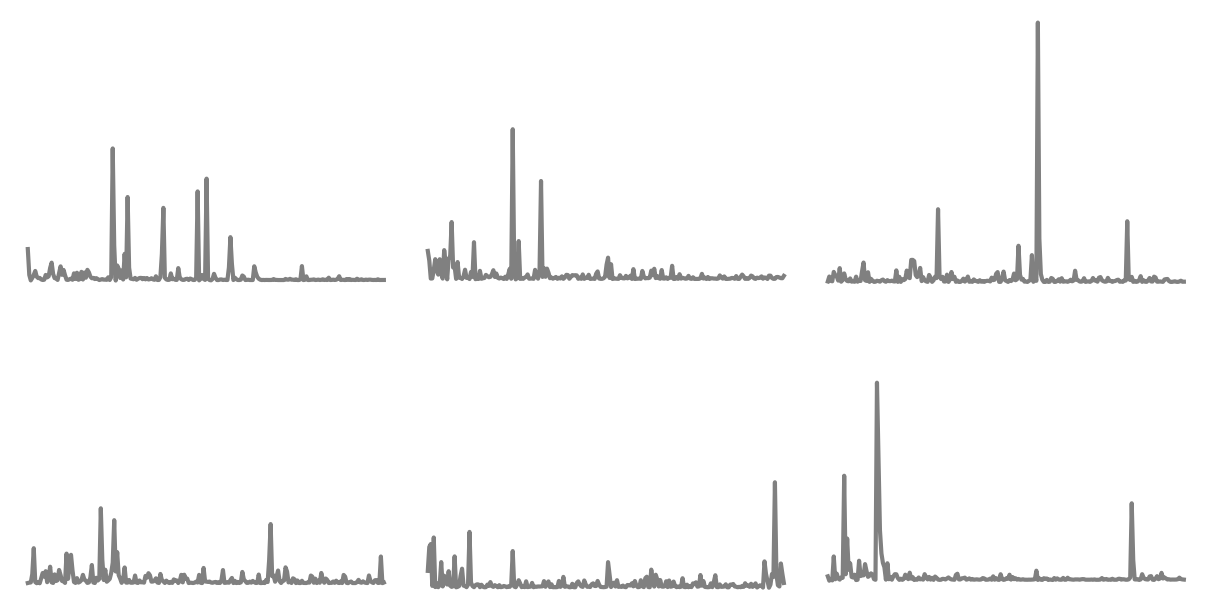

In [ ]:
# Random
fig,ax = plt.subplots(2,3, figsize=(12,6),sharex=True, sharey=True, layout='constrained')
axes = ax.ravel()

for i in range(len(axes)):

    node_series = series_gsr_w_before[random_nodes_idxs[i],:]

    axes[i].plot(node_series, 'gray', linewidth=3)
    # axes[i].set_title(random_nodes_idxs[i])
    axes[i].axis('off')

plt.savefig(f'../results/modularity/{BOT}/{BOT}_before_random_series.png', dpi=500, bbox_inches='tight')
plt.show()


After

[151, 282, 309, 313, 317, 323, 337, 340, 346, 348, 354, 358, 364, 382, 384, 388, 392]
[173  47 117 193 329 252]


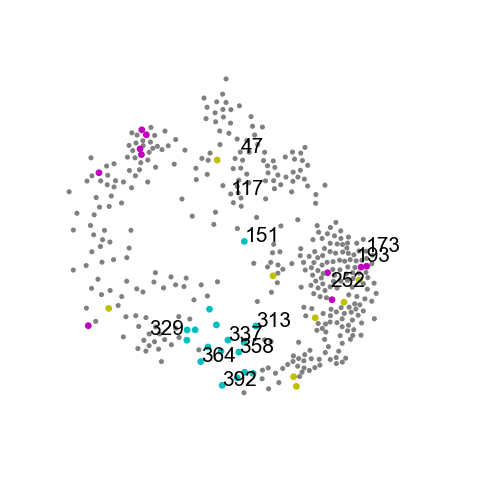

In [ ]:
# Find nodes of interest
MODULE = 0 # largest module
mask = consensus_partition2==comms_sorted_by_size2[MODULE][0]
nodes_idxs_in_modules = list(np.indices(mask.shape).reshape(len(mask))[mask])
after_nodes_of_interest = [151, 364, 392, 358, 313, 337] # bot_04 after, module 0 - first look at all nodes

np.random.seed(0)
all_node_idxs = list(com_df_after["series_index"])
remaining_nodes = list(set(all_node_idxs) - set(nodes_idxs_in_modules))
random_nodes_idxs = np.random.choice(remaining_nodes, 6).astype(int)

fig,ax = plt.subplots(layout='constrained')

# FC
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.setp(ax.spines.values(), visible=False)

background = np.ones((img_after.shape[0], img_after.shape[1])) # so nodes are in the same position as segmented cells above
ax.imshow(background, cmap='binary')
ax.scatter(com_df_after["y"], com_df_after["x"], c=NODE_COLOR_AFTER, s=NODE_SIZES_AFTER)

for row in com_df_after.iterrows():
    idx = int(row[1]['series_index'])
    if idx in after_nodes_of_interest:
        ax.annotate(idx, (com_df_after[com_df_after['series_index']==idx]["y"], com_df_after[com_df_after['series_index']==idx]["x"]))
    elif idx in random_nodes_idxs:
        ax.annotate(idx, (com_df_after[com_df_after['series_index']==idx]["y"], com_df_after[com_df_after['series_index']==idx]["x"]))
print(nodes_idxs_in_modules)
print(random_nodes_idxs)
plt.savefig(f'../results/modularity/{BOT}/{BOT}_after_network_key.png', dpi=500, bbox_inches='tight')
plt.show()

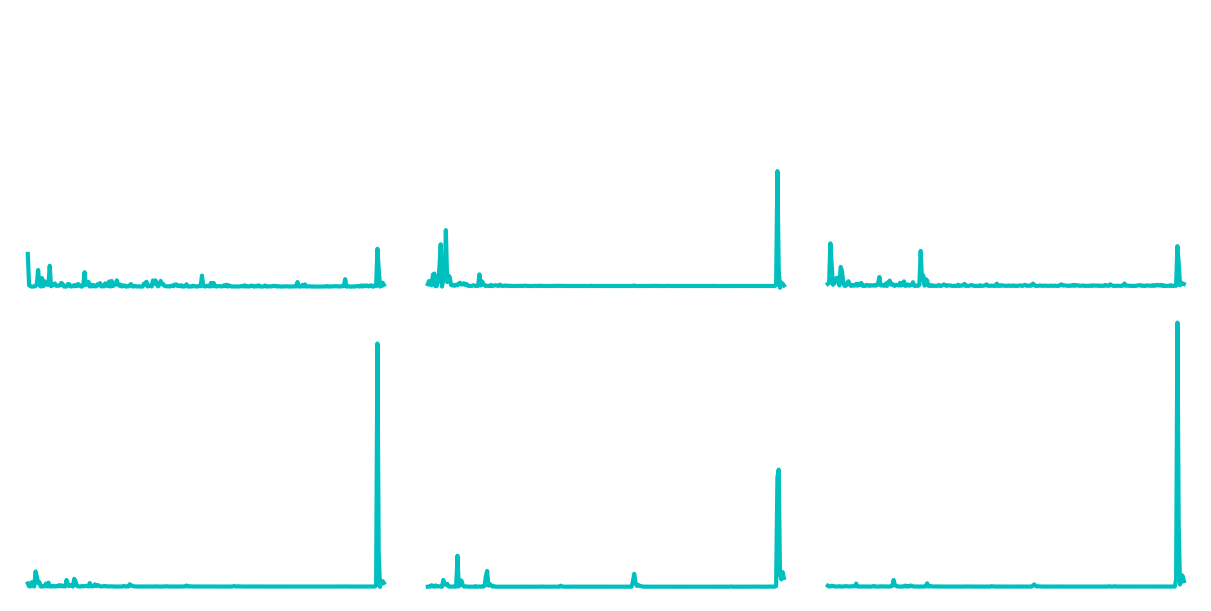

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(12,6),sharex=True, sharey=True, layout='constrained')
axes = ax.ravel()


for i in range(len(axes)):

    node_series = series_gsr_w_after[after_nodes_of_interest[i],:]

    axes[i].plot(node_series, CMAP2[MODULE], linewidth=3)
    # axes[i].set_title(after_nodes_of_interest[i])
    axes[i].axis('off')

plt.savefig(f'../results/modularity/{BOT}/{BOT}_after_module{MODULE}_series.png', dpi=500, bbox_inches='tight')
plt.show()

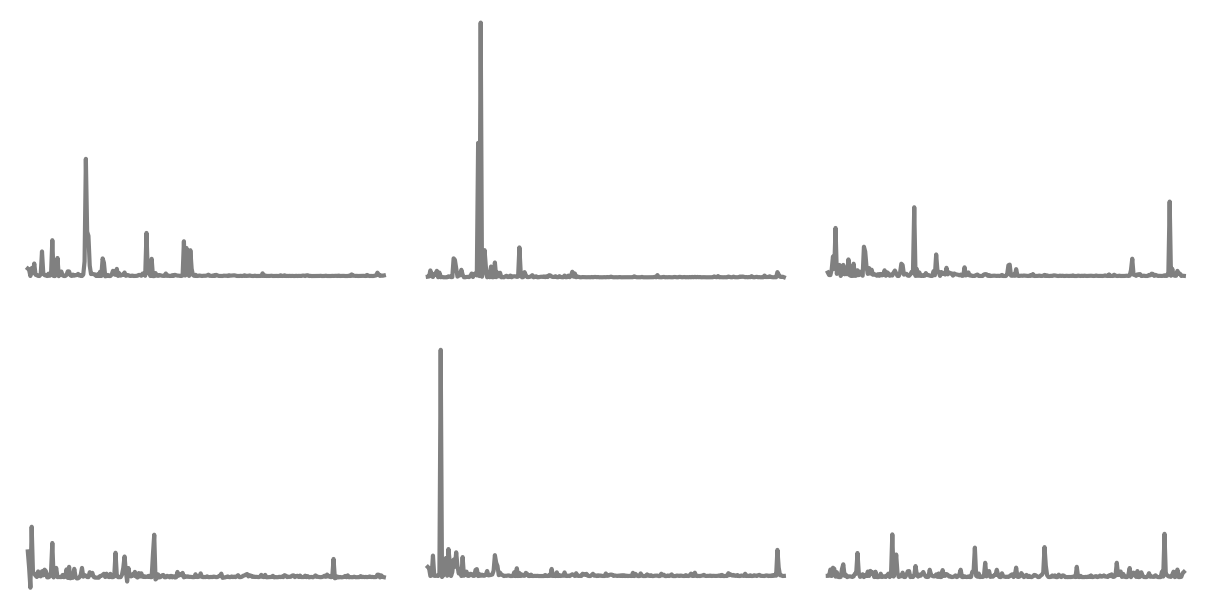

In [ ]:
# Random
fig,ax = plt.subplots(2,3, figsize=(12,6),sharex=True, sharey=True, layout='constrained')
axes = ax.ravel()

for i in range(len(axes)):

    node_series = series_gsr_w_after[random_nodes_idxs[i],:]

    axes[i].plot(node_series, 'gray', linewidth=3)
    # axes[i].set_title(random_nodes_idxs[i])
    axes[i].axis('off')

plt.savefig(f'../results/modularity/{BOT}/{BOT}_after_random_series.png', dpi=500, bbox_inches='tight')
plt.show()

### Module sizes

Before

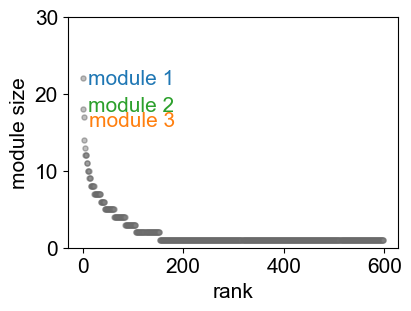

In [25]:
fig,ax = plt.subplots(figsize=(4,3), layout='constrained')
data = sorted(list(Counter(consensus_partition1).values()), reverse=True)
x = np.arange(len(data))
ax.scatter(x, data, s=13, edgecolors='dimgray', facecolors='gray', alpha=0.5)

ax.annotate('module 1', (x[0]+10,data[0]), color=CMAP1[0], va='center')
ax.annotate('module 2', (x[1]+10,data[1]+0.5), color=CMAP1[1], va='center')
ax.annotate('module 3', (x[2]+10,data[2]-0.5), color=CMAP1[2], va='center')
plt.xlabel('rank')
plt.ylim([0,30])
plt.ylabel('module size')
plt.savefig(f'../results/modularity/{BOT}/{BOT}_before_module_sizes.png', dpi=500, bbox_inches='tight')
plt.show()

After

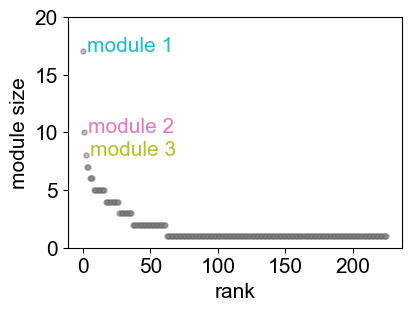

In [ ]:
fig,ax = plt.subplots(figsize=(4,3), layout='constrained')
data = sorted(list(Counter(consensus_partition2).values()), reverse=True)
x = np.arange(len(data))
ax.scatter(x, data, s=13, edgecolors='dimgray', facecolors='gray', alpha=0.5)

ax.annotate('module 1', (x[0]+3,data[0]), color=CMAP2[0])
ax.annotate('module 2', (x[1]+3,data[1]), color=CMAP2[1])
ax.annotate('module 3', (x[2]+3,data[2]), color=CMAP2[2])
plt.ylim([0,20])
plt.xlabel('rank')
plt.ylabel('module size')
plt.savefig(f'../results/modularity/{BOT}/{BOT}_after_module_sizes.png', dpi=500, bbox_inches='tight')
plt.show()